In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import librosa as lb
import pandas as pd
import glob
import os
import wave
import inspect
import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import Sampler, SubsetRandomSampler
import torch
import torch.optim as optim
from torch.autograd import Variable
import time
import seaborn as sb

In [2]:
 
def load_plot_rand_sample(datasetpath, label=0):
    """Load a .wav file from the dataset and displays it with the label
    
    Arguments:
    
    datasetpath : string, path to the training or testing set (must contain the train.csv file)
    """ 
    if not label:
        infos = pd.read_csv(os.path.join(datasetpath, "train.csv"))
        files = [y for x in os.walk(datasetpath) for y in glob.glob(os.path.join(x[0], '*.wav'))]
        index = np.random.randint(0,len(files)-1)
        print(index)
        print(files[index])
        data, sampling_rate = lb.load(files[index])
        label = infos.iloc[index].Class
    
    plt.plot(data)
    plt.title(label)
    plt.show()
    

# Dataset characterization
## Audio features statistics
Below I try loading each of the samples in the training set with audioread and build statistics about number of channels, samplerate and duration. Histograms of the results are shown.
#### IMPORTANT NOTE: some audio files will not load correctly if you have not installed ffmpeg before. 

In [5]:
trainpath = 'C:\\Users\\Copo\\source\\repos\\UrbanSoundClassification\\Data\\train'
testpath = 'C:\\Users\\Copo\\source\\repos\\UrbanSoundClassification\\Data\\submission_dataset'

In [21]:
files = [y for x in os.walk(trainpath) for y in glob.glob(os.path.join(x[0], '*.wav'))]

In [22]:
import IPython.display as display

In [23]:
index = 121
data, sr = lb.load(files[index], sr = 5025)
display.Audio(data, rate = sr)
data, sr = lb.load(files[index], sr = 44100)
display.Audio(data, rate = sr) 

In [24]:
#collect statistics on the train dataset
import audioread
channels = []
samplerates = []
durations = []
for filename in files:
    with audioread.audio_open(filename) as f:
        channels.append(f.channels)
        samplerates.append(f.samplerate)
        durations.append(f.duration) 


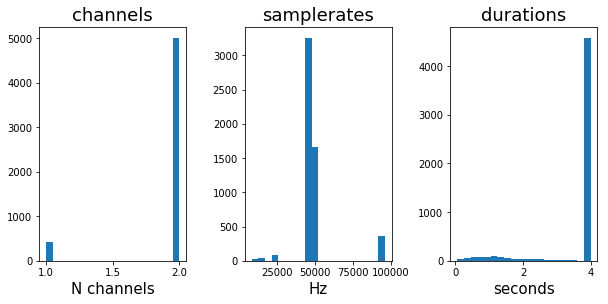

In [25]:
#plot the characteristics of the sounds in the dataset
stats = [channels, samplerates, durations]
labels = ['channels', 'samplerates', 'durations']
xlabels = ['N channels', 'Hz', 'seconds']
fig = plt.figure(figsize=(10,10))
k = -1
for stat in stats:
    k = k+1
    plt.subplot(1,3,k+1)
    plt.hist(stat,20)
    plt.title(labels[k], fontsize = 18)
    plt.xlabel(xlabels[k], fontsize = 15)
plt.subplots_adjust(top = 0.45, wspace = 0.4)
plt.show()

As we can see, there is variability in all the three sound characteristics unedr exhamination. We will make use of librosa and set some keywords arguments in the librosa.load() function in order to homogeneize the dataset. Librosa will automatically set the samplerate to 22050Hz and we will have to pass the 'mono' argument like such:

In [9]:
#example of how to load a sample with fixed nchannels
data, sr = lb.load(files[0], mono = True)
print(data.shape)
print(sr)

(88200,)
22050


Another problem is that the lengths of the audio files are not the same. The majority of samples is 4s long but there are quite a few that are shorter. To resolve this, we are going to pad the short samples with zeros before passing them to the model.

In [6]:
# there was a single sample that was longer than 4 seconds, this is the code to find out which one was it
lens=[]
lensT = []
shapes = []
for f in files:
    sample, sr = lb.load(f, sr=10025, mono=True)
    if len(sample) < 4*10025:
        sample = np.insert(sample, 0, np.zeros(4*10025 - len(sample)))
    lens.append((len(sample)))
    sample = torch.FloatTensor(sample)
    lensT.append(len(sample))
    sample = np.expand_dims(sample, 0)
    shapes.append(sample.shape)

In [11]:
np.where((np.array(lens)) != 40100)

(array([1484], dtype=int64),)

In [12]:
files [1484]

'C:\\Users\\Copo\\source\\repos\\UrbanSoundClassification\\Data\\train\\Train\\3190.wav'

## Dataset labels distribution
Next, let's check wheter we have a similar number of audio examples for each of the classes we want to classifiy. To do that we first load the train.csv file as a pandas dataframe, then we look at the number of different counts for each label.

In [46]:
infos = pd.read_csv(os.path.join(trainpath, "train.csv"))

In [47]:
infos[:10]

,ID,Class
0,0,siren
1,1,street_music
2,2,drilling
3,3,siren
4,4,dog_bark
5,6,children_playing
6,10,street_music
7,11,drilling
8,12,gun_shot
9,15,dog_bark


In [52]:
# get all the classes as a string
classes=list(set(infos.Class.values))

In [53]:
print(classes)

['children_playing', 'gun_shot', 'air_conditioner', 'siren', 'street_music', 'car_horn', 'jackhammer', 'engine_idling', 'dog_bark', 'drilling']


In [89]:
idd = files[11].split(os.sep)[-1].split('.')[0]

In [95]:
print(infos.loc[infos['ID'] == int(idd)]['Class'].values)


['drilling']


different sound categories : 
air_conditioner, engine_idling, gun_shot, jackhammer, street_music, drilling, children_playing, dog_bark, siren, car_horn


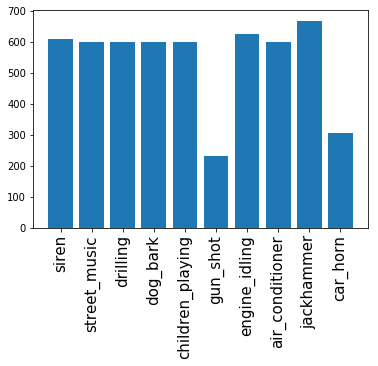

In [129]:
from collections import Counter

labels = ', '.join(list(set(infos['Class'])))
print(f'different sound categories : \n{labels}')

count_dict = Counter(infos['Class'])
Ns = []
for key, values in count_dict.items():
    Ns.append(values)
plt.bar(range(len(count_dict.keys())), Ns,)
plt.xticks(range(len(count_dict.keys())),  count_dict.keys(), rotation='vertical', fontsize = 15)

plt.show()

The dataset is fairly homogeneus but it has less gun shots and car horns. (I can understand it might hopefully be difficult to record gun shots in an urban environment but why such few ca horns??)

### Sample shuffling
Next we can ask wheter the same class of sounds appear contiguously in the dataset, e.g. all the drilling sounds are found in the fisrt 300 entries of the dataset, or if the dataset have been already shuffled. To do so lets look at the train.csv file and how the 'Class' column looks like.

In [105]:
# transorm each string representing a class into an integer between 1 and 10
classes = sorted(list(set(infos.Class)))
labels = []
for label_str in infos.Class.values:
    labels.append([i + 1 for i in range(len(classes)) if classes[i] == label_str][0])

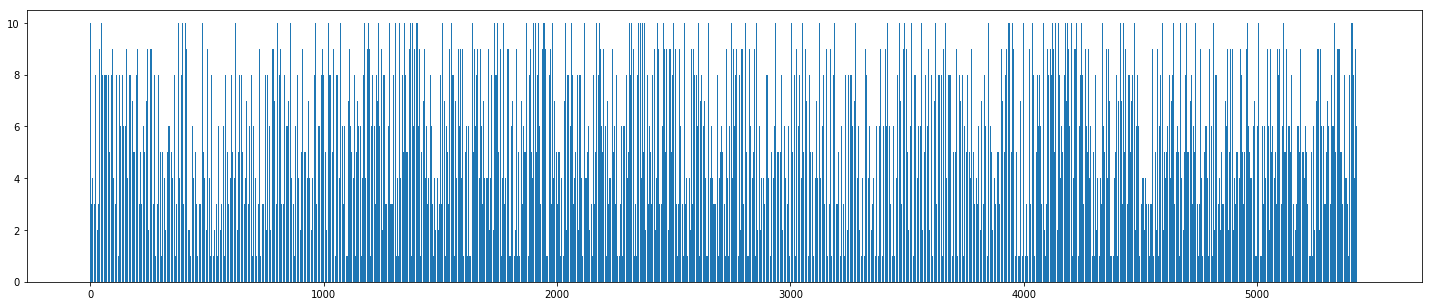

In [115]:
# visualize a bar plot for each label in the training set
plt.figure(figsize=(25,5))
plt.bar(range(len(labels)),labels)
plt.show()

By visual inspection we don't observe any evident clustering and we can assume the data is well shuffled.

# Dataset and Dataloaders for pytorch
### The Dataset class
Let's create a custom class inheriting from the Dataset class. 
I implemented data augmentation by allowing a shift of the start of the sample and padding it with zeros of 1/3 of the fixed sample lenght (6 seconds here).

In [3]:
import numpy as np
import librosa as lb
import pandas as pd
import torch
import glob
import os
from torch.utils.data import Dataset

def rollT(x, n):
    return torch.cat((x[-n:], x[:-n]))

class UrbanSoundDataset_aug(Dataset):

    def __init__(self, datapath, transforms, model_mode, sample_len=6 * 5000):
        self.model_mode = model_mode
        self.sample_len = sample_len
        self.path = datapath
        self.files = [y for x in os.walk(self.path) for y in glob.glob(os.path.join(x[0], '*.wav'))]
        self.len = len(self.files)
        self.transforms = transforms
        if self.model_mode == 'train':
            self.infos = pd.read_csv(os.path.join(self.path, 'train.csv'))
            self.classes = sorted(set(self.infos.Class))
        elif self.model_mode == 'test':
            self.infos = pd.read_csv(os.path.join(self.path, 'test.csv'))
            self.classes = sorted(set(self.infos.Class))
        elif self.model_mode == 'submission':
            self.infos = []
        else:
            print('WARNING: the train_or_test argument should be a string <train> or <test> ')
            1 / 0


    def __getitem__(self, index):
        sampleID = self.files[index].split(os.sep)[-1].split('.')[0]
        sample, sr = lb.load(self.files[index], sr=5000, mono=True)
        sample = sample - np.mean(sample)
        sample = sample / np.std(sample)
        sample = sample[:int(self.sample_len/2)]
        if len(sample) < self.sample_len:
            tmplen = len(sample)
            sample = np.insert(sample, 0, np.zeros(1+int(0.5 * (self.sample_len - tmplen) )))
            sample = np.insert(sample, len(sample), np.zeros(1+int(0.5 * (self.sample_len - tmplen) )))
        if len(sample) > self.sample_len:
            sample = sample[:self.sample_len]
        roll_len_max = int(self.sample_len/4)

        roll_len = int( (np.random.uniform()*2 -1) *roll_len_max )
        sample = torch.FloatTensor(sample)
        sample = rollT(sample, roll_len)

        sample = np.expand_dims(sample, 0)

        if self.transforms:
            sample = self.transforms(sample)
        if self.model_mode in ['train', 'test']:
            label_str = self.infos.loc[self.infos['ID'] == int(sampleID)].Class.values
            label = [i for i in range(len(self.classes)) if self.classes[i] == label_str]
            label = torch.LongTensor([label])[0][0]
            return (sample, label)
        else:
            return(sample, sampleID)

    def __len__(self):
        return self.len



In [11]:
train_dataset = UrbanSoundDataset_aug(trainpath, None, 'train')

In [29]:
train_loader = DataLoader(train_dataset, 10, shuffle = True)
sample, labels = next(iter(train_loader))
print(sample)
print(labels)
#the zeros at the beginning/end are due to the padding given the data augmentation implementation

tensor([[[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

        ...,

        [[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]],

        [[  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000]]])
tensor([3, 0, 9, 5, 6, 0, 5, 6, 1, 8])


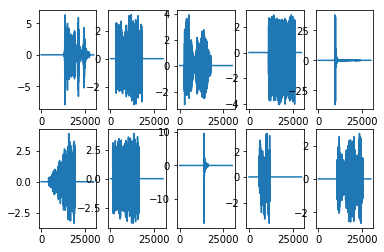

In [31]:
# visualize a minibatch
fig = plt.figure()
for s, i in zip(sample.numpy(), range(len(sample))):
    fig.add_subplot(2, int(len(sample)/2), i+1)
    plt.plot(s[0])
plt.show()

# Simple 1D conv approach 

In [4]:
import torch.nn.functional as F
from torch import nn

class Classifier1D_(nn.Module):

    def __init__(self):
        super(Classifier1D_, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, 9, padding=4)
        self.conv2 = nn.Conv1d(16, 32, 5, padding=2)
        self.conv3 = nn.Conv1d(32, 64, 5, padding=2)
        # self.conv4 = nn.Conv1d(64, 128, 5, padding=2)
        # self.conv5 = nn.Conv1d(128, 256, 5, padding=2)

        self.pool = nn.MaxPool1d(4, 4)
        # linear layer
        self.fc1 = nn.Linear(int(29952), 300)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(300, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        #x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        #x = self.dropout(x)
        # x = self.pool(F.relu(self.conv4(x)))
        # x = self.dropout(x)
        # x = self.pool(F.relu(self.conv5(x)))

        # flatten audio input
        x = x.view(10, -1)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = F.log_softmax(self.fc2(x), dim=1)
        return x



In [36]:
model = Classifier1D()

In [37]:
# let's see how our random untrained model perform on a random sample
sample, label = next(iter(train_loader))
print(torch.exp(model(sample)).topk(1,dim=1)[1].t())
print(label)


tensor([[5, 8, 2, 5, 2, 9, 7, 2, 2, 5]])
tensor([7, 5, 0, 0, 0, 5, 3, 4, 0, 9])


# Training script

In [7]:

trainpath = 'C:\\Users\\Copo\\source\\repos\\UrbanSoundClassification\\Data\\train'
testpath = 'C:\\Users\\Copo\\source\\repos\\UrbanSoundClassification\\Data\\test'
validationpath = 'C:\\Users\\Copo\\source\\repos\\UrbanSoundClassification\\Data\\validation'
savepath = 'C:\\Users\\Copo\\source\\repos\\UrbanSoundClassification\\trainings\\' + ''.join('_'.join(time.ctime().split()).split(':')) + '_1DCNN_twoMORELAYERandDOonemoreFC'
try:
    os.mkdir(savepath)
except:
    print('directory already exists')
resume = 0

batch_size = 10
epochs = 10

DS = UrbanSoundDataset(trainpath, None, 'train')

num_train = len(DS)
testval_fraction = 0.3
indices = list(range(num_train))
split_idx = int(num_train*(1-testval_fraction))
train_idx = indices[:split_idx]

train_sampler = SubsetRandomSampler(train_idx)

indices_testval = indices[split_idx:]
split_idx_testval = int(num_train*testval_fraction*0.5)
val_idx = indices_testval[:split_idx_testval]
test_idx = indices_testval[split_idx_testval:]

val_sampler = SubsetRandomSampler(val_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(DS, batch_size=batch_size,
                          drop_last=True, sampler=train_sampler)
val_loader = DataLoader(DS, batch_size=batch_size,
                          drop_last=True, sampler=val_sampler)
test_loader = DataLoader(DS, batch_size=batch_size,
                          drop_last=True, sampler=test_sampler)

#saves the sampler indeces for the specific training
np.save(os.path.join(savepath, 'train_idx.npy'), np.array(train_idx))
np.save(os.path.join(savepath, 'test_idx.npy'), np.array(test_idx))
np.save(os.path.join(savepath, 'val_idx.npy'), np.array(val_idx))



if resume:
    savepath = r'C:\Users\Copo\source\repos\UrbanSoundClassification\trainings\Tue_Feb_19_173459_2019_1DCNN_twoMORELAYERandDO'
    model_with_val = torch.load(os.path.join(savepath,'model_epoch_3.pt'))
    train_loss_overtime = list(np.load(os.path.join(savepath,'trainloss.npy')))
    test_loss_overtime = list(np.load(os.path.join(savepath,'validationloss.npy')))
    starting_epoch = 4
else:
    train_loss_overtime = []
    test_loss_overtime = []
    model_with_val = Classifier1D()
    #model_with_val = FullyConnected()
    starting_epoch = 0
model_with_val.to('cuda')
print(model_with_val)
# train script with validation

criterion = nn.NLLLoss()
optimizer = optim.Adam(model_with_val.parameters(), lr=0.0001)

for e in range(starting_epoch, starting_epoch + epochs):

    train_loss = 0.0
    test_loss = 0.0
    model_with_val.train()
    status = 0
    for sample, label in train_loader:
        status += 1
        if status % 10 == 0:
            print(f'epoch progress: {int (status*batch_size/len(train_loader.dataset)*100)}%')
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        sample = Variable(sample.to('cuda'))
        output = model_with_val(sample)
        output.to('cuda')
        # calculate the batch loss
        label = Variable(label.to('cuda'))
        loss = criterion(output, label)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item() * sample.size(0)

    ######################
    # validate the model #
    ######################
    model_with_val.eval()
    status = 0
    for data, target in val_loader:

        status += 1
        if status % 2 == 0:
            print(f'validating: {int (status*batch_size/len(val_loader.sampler)*100)}%')
        # forward pass: compute predicted outputs by passing inputs to the model
        data = Variable(data.to('cuda'))
        output = model_with_val(data)
        output.to('cuda')
        target = Variable(target.to('cuda'))
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        test_loss += loss.item() * data.size(0)

    # calculate average losses
    train_loss = train_loss / len(train_loader.dataset)
    test_loss = test_loss / len(val_loader.dataset)

    test_loss_overtime.append(test_loss)
    train_loss_overtime.append(train_loss)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e, train_loss, test_loss))
    if e > starting_epoch and test_loss_overtime[e-starting_epoch] < min(test_loss_overtime[:-1]):
        torch.save(model_with_val, os.path.join(savepath, f'model_epoch_{e}.pt'))

    np.save(os.path.join(savepath, 'trainloss.npy'), np.array(train_loss_overtime))
    np.save(os.path.join(savepath, 'validationloss.npy'), np.array(test_loss_overtime))



NameError: name 'UrbanSoundDataset' is not defined

# Visualize learned representation of a trained model
After training a 1D convolutional neural network having about 70% test accuracy, I want to visually inspect what kind of internal representation have the convulutional layer developed.

In [59]:
# load the trained "Classifier1D" model and dataloaders
os.chdir(r'C:\Users\Copo\source\repos\UrbanSoundClassification\Source\\')
import Classifier1D
from UrbanSoundDataset_aug import *
loadpath = r'C:\Users\Copo\source\repos\UrbanSoundClassification\trainings\Fri_Feb_22_180608_2019_1DCNN_3layers_shorteersmaples'
model_full = torch.load(os.path.join(loadpath,'model_epoch_0.pt'))

test_idx = np.load(os.path.join(loadpath, 'test_idx.npy'))

trainpath = r'C:\\Users\\Copo\\source\\repos\\UrbanSoundClassification\\Data\\train'
DS = UrbanSoundDataset_aug(trainpath, None, 'train')

batch_size = 10
test_sampler = SubsetRandomSampler(test_idx)
test_loader = DataLoader(DS, batch_size=batch_size,
                          drop_last=True, sampler=test_sampler)

D:\Python\lib\site-packages\torch\serialization.py:425: SourceChangeWarning: source code of class 'Classifier1D.Classifier1D' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [41]:
# truncate the model until before the Fully Connected layers
model_truncated = nn.Sequential(nn.Sequential(*list( model_full.children())[:-3]))

In [42]:
model_truncated.cpu()

Sequential(
  (0): Sequential(
    (0): Conv1d(1, 16, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): Conv1d(16, 32, kernel_size=(5,), stride=(1,), padding=(2,))
    (2): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
    (3): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
)

In [43]:
sample, label = next(iter(test_loader))

In [44]:
out = model_truncated(sample.cpu()).detach().numpy()

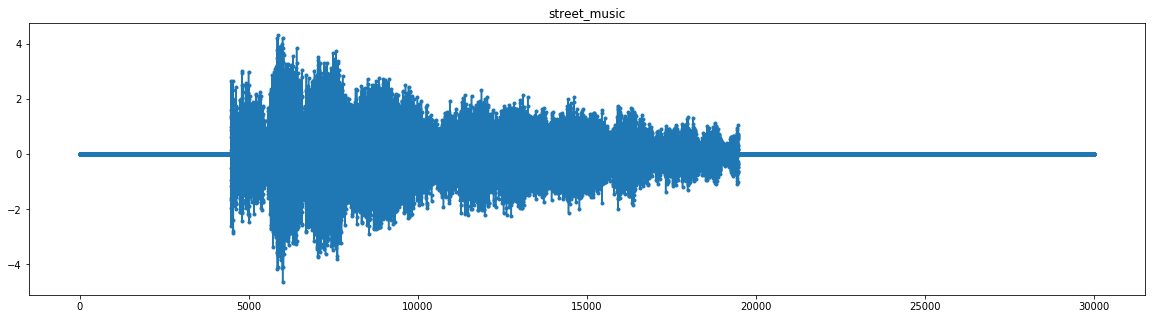

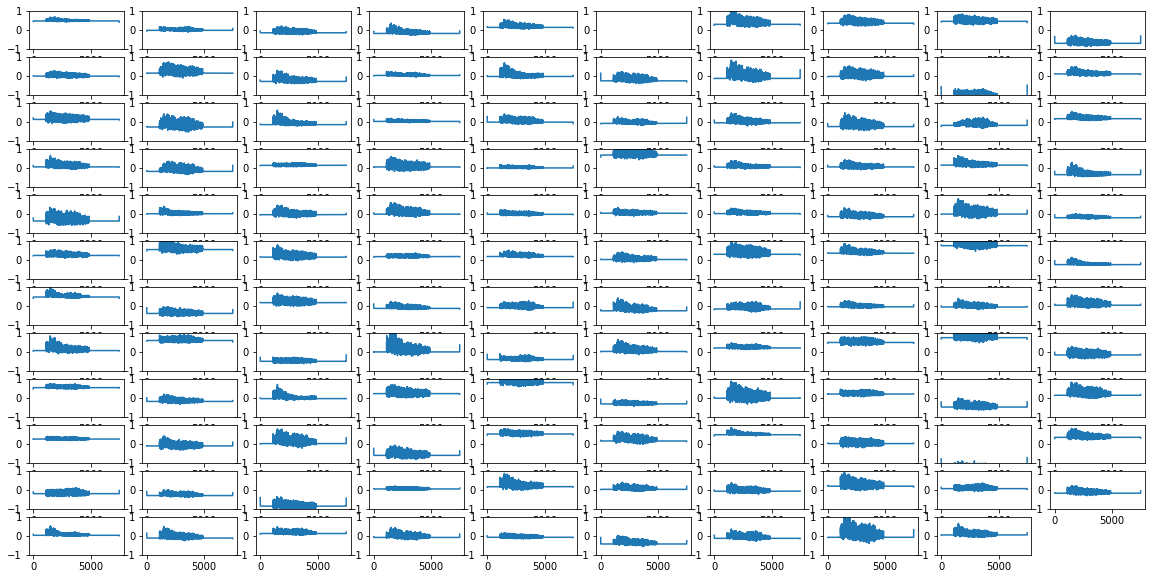

In [59]:
# for a given sample plot the (processed) sample itself and each of the 64 slices of the last convolutional hidden layer
ind = 4
ff = plt.figure(figsize=(20,5))
plt.plot(sample[ind][0].numpy(),'.-')
plt.title(classes[ind])
f = plt.figure(figsize=(20,10))

for i in range(1,out.shape[1]-8):
    f.add_subplot(12,10,i)
    plt.plot(out[ind][i-1])
    plt.ylim([-1,1])
plt.show()

we can see that some of the neurons contribute less than others which is a sign of learning. Nevertheless, our model seems to reach a limit at around 70% accuracy that does not seem to improve by changing network architecture or hyperparameters (I tried different n_hidden, different filter sizes, different max pooling ..). So we might need to change arhitecture. 
Before that let's understand if our model is underfitting or overfitting by doing the following:

1) plot learning curves.

2) compute precision and recall.

# Learning curves

Let's create a function that train our 1D classifier over an increasing number of samples and look at the train and test accuracy as a function of training set size then plots the curves.

In [9]:
class SubsetSequentialSampler(Sampler):

    """Samples elements sequentially from a given list of indices, always in the same order.
    Arguments:
        indices (list): a list of indices
    """
 
    def __init__(self, indices):
        self.num_samples = len(indices)
        self.indices = indices
    
    def __iter__(self): 
        return iter(self.indices)
 
    def __len__(self):
        return self.num_samples

In [29]:

#def plot_learning_curves(training_size_increment = 50, N_iterations = 10, N_epochs = 10):
#     """
#     Train a model for increasing number of samples (increasing in fixed steps or minibatches) 
#     and plot the learning curve by comparing the trin and the cross-validation accuracy.
    
#     Arguments:
    
#     training_size_increment : int, number of samples to be added to the training set at each iteration
#     N_iterations:             int, how many different sizes we want to train on.
#     N_epochs:                 int, for each iteration how many epochs we want to train on.
#     """

training_size_increment = 50
N_iterations = 10
N_epochs = 5
#create the dataset
trainpath = r'C:\\Users\\Copo\\source\\repos\\UrbanSoundClassification\\Data\\train'
DS = UrbanSoundDataset_aug(trainpath, None, 'train')
num_train = len(DS)
trainval_fraction = 0.2
batch_size = 10

#gets the indices and shuffle them
indices = list(range(num_train))
np.random.shuffle(indices)

#split into validation and train set
split_idx = int(num_train*(1-trainval_fraction))
train_idx = list(indices[:split_idx])
val_idx = list(indices[split_idx:])

# train and val loss after each iteration
train_loss_aftertraining = []
val_loss_aftertraining = []

#start iterating the N trainings with different sizes of ts
for i in range(N_iterations):
    print(f'iteration {i} \n\n')
    # create a new model and move to gpu
    model = Classifier1D_()
    model.to('cuda')

    # define the new number of training examples
    N_samples = 2*training_size_increment + i*training_size_increment
    train_loader = DataLoader(DS, batch_size=batch_size,
                          drop_last=True, sampler=SubsetSequentialSampler(train_idx[:N_samples]))
    val_loader = DataLoader(DS, batch_size=batch_size,
                          drop_last=True, sampler=SubsetSequentialSampler(val_idx[:int(trainval_fraction*N_samples)]))

    #define loss and optimizer
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00051)

    for e in range(N_epochs):
        train_loss = 0.0
        val_loss = 0.0
        model.train()
        status = 0
        print(f'epoch {e} progress: ', end=' ') 
        for sample, labels in train_loader:
            status += 1
            if status % 5 == 0:
                print(f'{int (status/len(train_loader)*100)}%', sep=', ', end=' ')
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            sample = Variable(sample.to('cuda'))
            output = model(sample)
            output.to('cuda')
            # calculate the batch loss
            labels = Variable(labels.to('cuda'))
            loss = criterion(output, labels)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += loss.item() 
    train_loss_aftertraining.append(train_loss/len(train_loader))

    ######################
    # validate the model after training for N_epochs #
    ######################
    model.eval()
    status = 0
    for data, target in val_loader:

        status += 1
        if status % 2 == 0:
            print(f'validating: {int (status*batch_size/len(val_loader.sampler)*100)}%', sep=', ', end=' ')
        # forward pass: compute predicted outputs by passing inputs to the model
        data = Variable(data.to('cuda'))
        output = model(data)
        output.to('cuda')
        target = Variable(target.to('cuda'))
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        val_loss += loss.item() 

    val_loss_aftertraining.append(val_loss/len(val_loader))
    print('\n')
    
#     return train_loss_aftertraining, val_loss_aftertraining

# tl, vl = plot_learning_curves()

iteration 0 


epoch 0 progress:  epoch 0 progress: 50% epoch 0 progress: 100% epoch 1 progress:  epoch 1 progress: 50% epoch 1 progress: 100% epoch 2 progress:  epoch 2 progress: 50% epoch 2 progress: 100% epoch 3 progress:  epoch 3 progress: 50% epoch 3 progress: 100% epoch 4 progress:  epoch 4 progress: 50% epoch 4 progress: 100% validating: 100% 

iteration 1 


epoch 0 progress:  epoch 0 progress: 33% epoch 0 progress: 66% epoch 0 progress: 100% epoch 1 progress:  epoch 1 progress: 33% epoch 1 progress: 66% epoch 1 progress: 100% epoch 2 progress:  epoch 2 progress: 33% epoch 2 progress: 66% epoch 2 progress: 100% epoch 3 progress:  epoch 3 progress: 33% epoch 3 progress: 66% epoch 3 progress: 100% epoch 4 progress:  epoch 4 progress: 33% epoch 4 progress: 66% epoch 4 progress: 100% validating: 66% 

iteration 2 


epoch 0 progress:  epoch 0 progress: 25% epoch 0 progress: 50% epoch 0 progress: 75% epoch 0 progress: 100% epoch 1 progress:  epoch 1 progress: 25% epoch 1 progress: 5

10

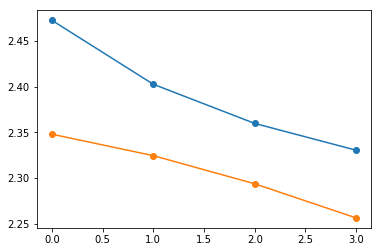

In [28]:
plt.plot(train_loss_aftertraining,'-o')
plt.plot(val_loss_aftertraining,'-o')
plt.show()


In [23]:
train_loss_aftertraining

[122.94533014297485,
 237.346031665802,
 353.03842306137085,
 468.1058406829834,
 578.5411024093628]

# 2D Convolutional Neural Network approach

In [1]:
# model implementation

In [2]:
# dataset modified

After training a 2D CNN for about 10 epochs I achieved an accuracy on the test set of 86% which is not bad. Here is how the train and validation loss looked like.

In [36]:
loss_path = r'C:\Users\Copo\source\repos\UrbanSoundClassification\trainings2D\Sat_Feb_23_165712_2019_1DCNN_longersamples'
train_loss2DCNN_1 = np.load(os.path.join(loss_path, 'trainloss.npy')) 
val_loss2DCNN_1 = np.load(os.path.join(loss_path, 'validationloss.npy')) 


Text(0, 0.5, 'loss')

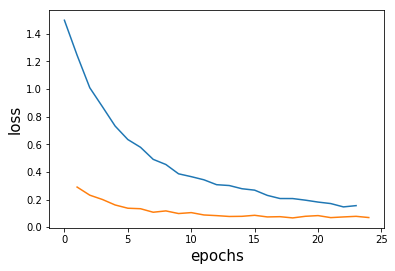

In [100]:
# plot the train and validation loss for the first training with th 2D CNN
sb.lineplot(range(len(train_loss2DCNN_1)), train_loss2DCNN_1)
sb.lineplot(range(1,len(val_loss2DCNN_1)+1), val_loss2DCNN_1)
plt.xlabel('epochs', fontsize=15)
plt.ylabel('loss', fontsize=15)

Both the train and the validation loss behave well during training so there should be no risk of over/underfitting if I increase the dataset size. 
Even though the losses look goos, the accuracy on the submission test was only 62%. Let's check if there is something weird in the submission dataset.

In [6]:
files_test = [y for x in os.walk(testpath) for y in glob.glob(os.path.join(x[0], '*.wav'))]

In [7]:
#collect statistics on the test dataset
import audioread
channels_test = []
samplerates_test = []
durations_test = []
for filename in files_test:
    with audioread.audio_open(filename) as f:
        channels_test.append(f.channels)
        samplerates_test.append(f.samplerate)
        durations_test.append(f.duration) 


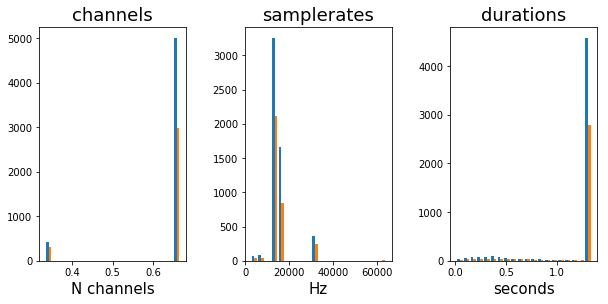

In [34]:
#plot the characteristics of the sounds in the test dataset
stats_test = [channels_test, samplerates_test, durations_test]
stats_train = [channels, samplerates, durations]
labels = ['channels', 'samplerates', 'durations']
xlabels = ['N channels', 'Hz', 'seconds']
fig = plt.figure(figsize=(10,10))
k = -1
for stat_train, stat_test in zip(stats_train, stats_test):
    k = k+1
    plt.subplot(1,3,k+1)
    plt.hist([np.array(stat_train)/len(stats_train), np.array(stat_test)/len(stats_test)],20)
    #sb.distplot(stat_test,20)
    plt.title(labels[k], fontsize = 18)
    plt.xlabel(xlabels[k], fontsize = 15)
plt.subplots_adjust(top = 0.45, wspace = 0.4)
plt.show()

Since it doesn't look like there is any difference or anomaly in the distributions of the files' parameters, maybe increasing the size of the training set for instance by running a training of the 2D CNN with the same setting as the one that gave 86% accuracy but using the full labeled dataset (without splitting into val and test) and and try submission again.

In [57]:
import time
for i in range(1,20):
    print('-'*i + f'{i}' + (20-i-1)*' ' + '20||', end = '', flush=True)
    print('\r', end='')
    time.sleep(0.5)

In [89]:
import time
status = 0
print_every=10
for sample in range(len(test_loader)):
    status += 1
    if status % print_every == 0:
        print('-'*int(status/print_every),
                     end=f'{int(status/len(test_loader)*100)}%' +
                         ' '*(int(len(test_loader)/print_every) - int(status/print_every)) + '100%||', flush =True)
        print('\r', end='')
        time.sleep(0.1)

In [102]:
a=2; a='two'